# Objective Function

## Given:
- $ \mathbf{x}' \in \mathbb{R}^d $: Target variable (Counterfactual Explanation).
- $ \mathbf{x} \in \mathbb{R}^d $: Conditional variable (Data Point).
- $ d = \|\mathbf{x} - \mathbf{x}'\|_2^2 $: Proximity (distance).
- $ p_\theta(\mathbf{x}' | \mathbf{x}, d(\mathbf{x}', \mathbf{x})) $: Conditional density modeled by the flow.

The optimization objective with an $ \ell_2 $-penalty is defined as:

$$
\mathcal{L}(\theta) = - \log p_\theta(\mathbf{x}' | \mathbf{x}, d(\mathbf{x}', \mathbf{x})),
$$

where the flow-based model defines the conditional density as:

$$
\log p_\theta(\mathbf{x}' | \mathbf{x}, d(\mathbf{x}', \mathbf{x})) = \log p_\theta(\mathbf{z}) - \log \left| \det \frac{\partial f_\theta(\mathbf{x}', \mathbf{x}, d)}{\partial \mathbf{x}'} \right|,
$$

with:
- $ \mathbf{z} = f_\theta(\mathbf{x}', \mathbf{x}, d(\mathbf{x}', \mathbf{x})) $: Latent representation via the flow $ f_\theta $.
- $ p_\theta(\mathbf{z}) $: Density in the latent space.

### Expanded Form:
Substituting the density transformation formula, the objective becomes:

$$
\mathcal{L}(\theta) = - \log p_\theta(f_\theta(\mathbf{x}', \mathbf{x}, d(\mathbf{x}', \mathbf{x}))) + \log \left| \det \frac{\partial f_\theta(\mathbf{x}', \mathbf{x}, d)}{\partial \mathbf{x}'} \right|.
$$

---

# Optimization Problem

The goal is to find the optimal parameter $ \theta^* $ that minimizes the objective function:

$$
\theta^* = \arg\min_\theta \mathcal{L}(\theta).
$$

In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from matplotlib import cm
from torch.utils.data import DataLoader, Dataset


from counterfactuals.datasets.moons import MoonsDataset
from counterfactuals.generative_models import MaskedAutoregressiveFlow
from counterfactuals.discriminative_models import MultilayerPerceptron
from counterfactuals.cf_methods.gence.gence_cond import GenCECond

In [3]:
class PairDataset(Dataset):
    def __init__(self, class_zero, class_one, length=None):
        """
        Initialize with two arrays, one for each class.
        """
        self.length = length
        self.class_zero = class_zero
        self.class_one = class_one
        self.size_zero = class_zero.shape[0]
        self.size_one = class_one.shape[0]

    def __len__(self):
        # The total combinations are len(class_zero) * len(class_one)
        if self.length is not None:
            return self.length
        return self.size_zero * self.size_one

    def __getitem__(self, idx):
        # randomly select one from each class
        i = torch.randint(0, self.size_zero, (1,)).item()
        j = torch.randint(0, self.size_one, (1,)).item()

        x = self.class_zero[i]
        y = self.class_one[j]

        if torch.rand(1) > 0.5:
            x, y = y, x

        return torch.tensor(x, dtype=torch.float32), torch.tensor(
            y, dtype=torch.float32
        )

In [4]:
dataset = MoonsDataset(file_path="../data/moons.csv")

In [5]:
dataset = MoonsDataset(file_path="../data/moons.csv")
disc_model = MultilayerPerceptron(
    input_size=2, hidden_layer_sizes=[256, 256], target_size=1, dropout=0.2
)
train_dataloader = dataset.train_dataloader(batch_size=64, shuffle=True, noise_lvl=0.0)
test_dataloader = dataset.test_dataloader(batch_size=64, shuffle=False)
disc_model.fit(train_dataloader, test_dataloader, epochs=10000, patience=300, lr=1e-3)
# disc_model.load("../models/MoonsDataset/disc_model_MultilayerPerceptron.pt")

disc_model.eval()
dataset.y_train = disc_model.predict(dataset.X_train).detach().numpy()
dataset.y_test = disc_model.predict(dataset.X_test).detach().numpy()

  0%|          | 0/10000 [00:00<?, ?it/s]/Users/ofurman/Private/counterfactuals/counterfactuals/discriminative_models/multilayer_perceptron.py:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

In [6]:
flow_train_dataloader = dataset.train_dataloader(
    batch_size=128, shuffle=True, noise_lvl=0.03
)
flow_test_dataloader = dataset.test_dataloader(batch_size=128, shuffle=False)
flow = MaskedAutoregressiveFlow(
    features=dataset.X_test.shape[1],
    hidden_features=16,
    num_blocks_per_layer=4,
    num_layers=8,
    context_features=1,
)
flow.fit(flow_train_dataloader, flow_test_dataloader, num_epochs=1000, patience=50)

Epoch 128, Train: -1.2561, test: -1.4630, patience: 50:  13%|█▎        | 128/1000 [00:07<00:52, 16.67it/s]
/Users/ofurman/Private/counterfactuals/counterfactuals/generative_models/maf.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue 

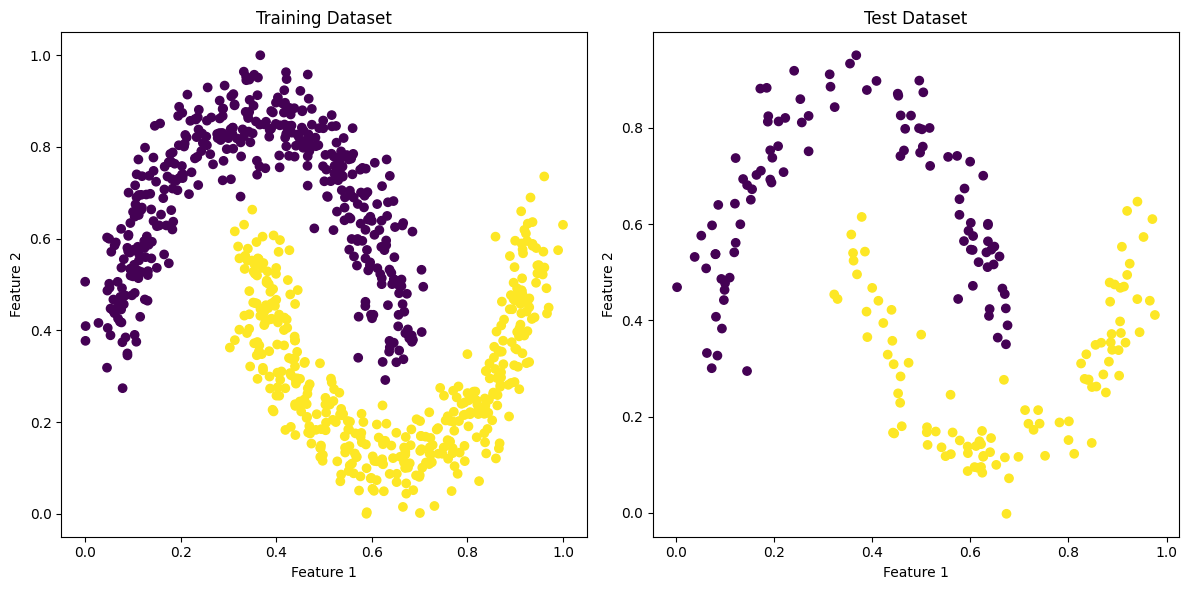

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot training dataset
axes[0].scatter(dataset.X_train[:, 0], dataset.X_train[:, 1], c=dataset.y_train, cmap='viridis', marker='o')
axes[0].set_title('Training Dataset')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

# Plot test dataset
axes[1].scatter(dataset.X_test[:, 0], dataset.X_test[:, 1], c=dataset.y_test, cmap='viridis', marker='o')
axes[1].set_title('Test Dataset')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

In [8]:
class_zero = dataset.X_train[dataset.y_train == 0]
class_one = dataset.X_train[dataset.y_train == 1]

pair_dataset_train = PairDataset(class_zero, class_one, length=5000)


def collate_fn(batch):
    X, y = zip(*batch)
    X = torch.stack(X)
    y = torch.stack(y)
    noise = torch.randn_like(X) * 0.03
    noise = torch.randn_like(y) * 0.03
    X = X + noise
    y = y + noise
    return X, y


train_dataloader = DataLoader(
    pair_dataset_train, batch_size=256, shuffle=True, collate_fn=collate_fn
)

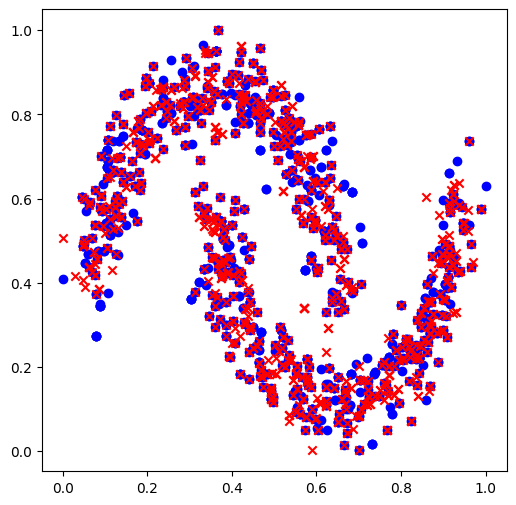

In [9]:
x_cfs, x_origs = [], []
for i in range(1000):
    x_cf, x_orig = pair_dataset_train[i]
    x_cfs.append(x_cf)
    x_origs.append(x_orig)
x_cfs = torch.vstack(x_cfs)
x_origs = torch.vstack(x_origs)

plt.figure(figsize=(6, 6))
plt.scatter(x_cfs[:, 0], x_cfs[:, 1], c='blue', marker='o', label='Counterfactual')
plt.scatter(x_origs[:, 0], x_origs[:, 1], c='red', marker='x', label='Original')

In [10]:
class_zero = dataset.X_test[dataset.y_test == 0]
class_one = dataset.X_test[dataset.y_test == 1]

pair_dataset_test = PairDataset(class_zero, class_one)

test_dataloader = DataLoader(pair_dataset_test, batch_size=2048, shuffle=False)

In [29]:
cf = GenCECond(
    features=2,
    hidden_features=16,
    num_blocks_per_layer=4,
    num_layers=8,
    context_features=3,
)
cf.fit(
    train_dataloader,
    test_dataloader,
    alpha=2.0,
    num_epochs=1000,
    learning_rate=3e-4,
    patience=100,
)

Epoch 999, Train: -3.7600, test: -3.7525, patience: 2: 100%|██████████| 1000/1000 [06:18<00:00,  2.64it/s]
/Users/ofurman/Private/counterfactuals/counterfactuals/cf_methods/gence/gence_cond.py:158: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an 

In [30]:
from counterfactuals.plot_utils import plot_generative_model_distribution

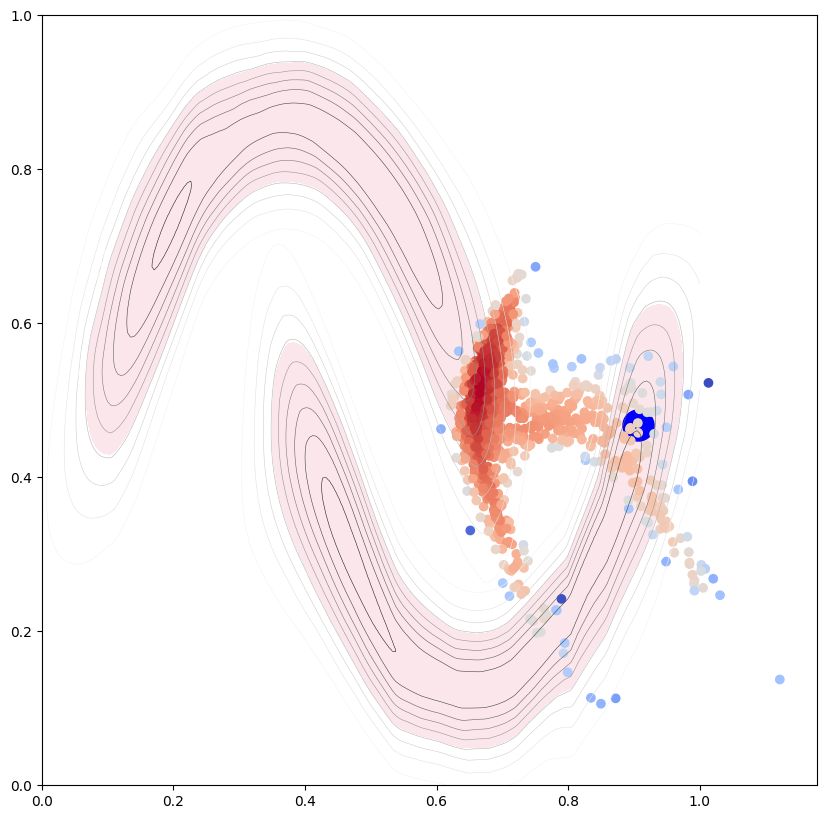

In [51]:
i = 5
with torch.no_grad():
    context = torch.from_numpy(np.array([class_one[i]]))
    context = torch.hstack([context, torch.Tensor([[0.25]])])
    points, log_prob = cf.sample_and_log_prob(1000, context=context)

points = points.squeeze().numpy()
# plot points with colorized log prob
# fig, ax = plt.figure(figsize=(10, 10))
fig, ax = plt.subplots(figsize=(10, 10))
plot_generative_model_distribution(ax, flow, 1.2, 2)
ax.scatter(class_one[i, 0], class_one[i, 1], c="blue", s=500)
ax.scatter(points[:, 0], points[:, 1], c=log_prob, cmap=cm.coolwarm)

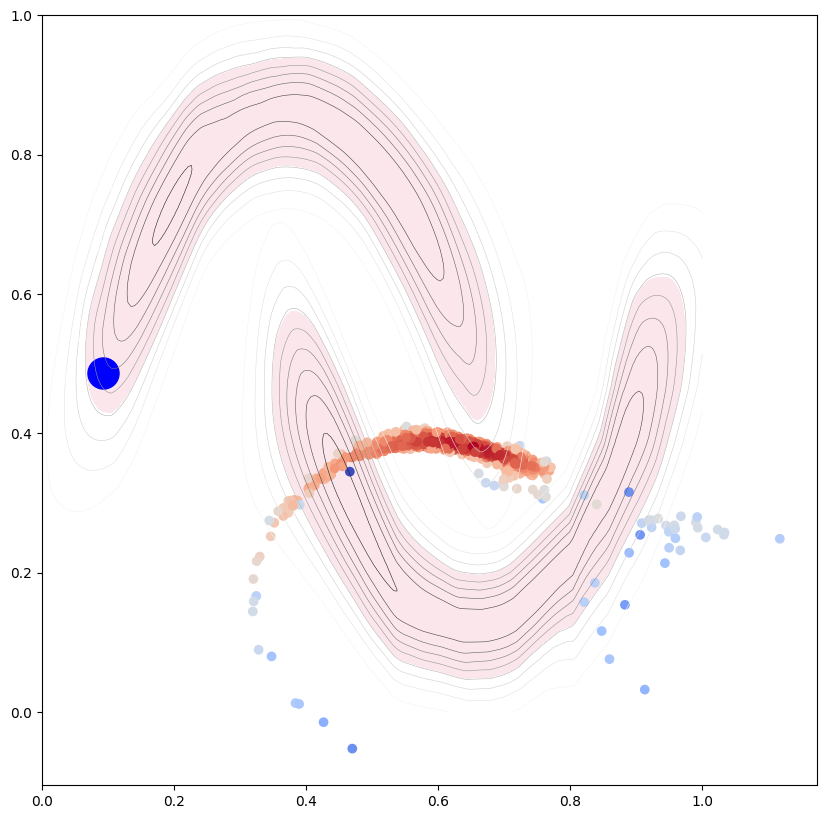

In [50]:
i = 44
with torch.no_grad():
    context = torch.from_numpy(np.array([class_one[i]]))
    context = torch.hstack([context, torch.Tensor([[0.3]])])
    points, log_prob = cf.sample_and_log_prob(1000, context=context)

points = points.squeeze().numpy()
# plot points with colorized log prob
fig, ax = plt.subplots(figsize=(10, 10))
plot_generative_model_distribution(ax, flow, 1.2, 2)
ax.scatter(class_zero[i, 0], class_zero[i, 1], c="blue", s=500)
ax.scatter(points[:, 0], points[:, 1], c=log_prob, cmap=cm.coolwarm)